# Notebook 5: Threshold Optimization & Comprehensive Model Evaluation

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** [Your Name]  
**Date:** 2025  

---

## 📋 Notebook Objectives

1. **Test set evaluation** — Final performance on held-out data (no peeking during training!)
2. **Threshold optimization** — Find optimal confidence threshold for deployment
3. **ROC & PR curves** — Multi-class diagnostic performance analysis
4. **t-SNE visualization** — Visualize learned feature representations
5. **Error analysis** — Identify misclassification patterns
6. **Scientific figures** — Publication-ready visualizations
7. **Final metrics summary** — Comprehensive performance report

---

## ⚠️ Important: Test Set Integrity

This notebook evaluates on the **TEST SET** which was:
- Never used during training
- Never used for hyperparameter tuning
- Never used for model selection

Results here represent the **true generalization performance** of our model.

---

## 1. Environment Setup

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import json
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve, auc,
    precision_score, recall_score, f1_score, accuracy_score,
    average_precision_score, roc_auc_score
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

from tqdm.notebook import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
%matplotlib inline

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"\nNotebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070 Ti Laptop GPU

Notebook executed at: 2026-01-26 13:38:13


In [2]:
# =============================================================================
# PROJECT PATHS & CONFIGURATION
# =============================================================================

class ProjectPaths:
    """Centralized path management."""
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    DATA_PROCESSED = ROOT / "data" / "processed"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CHECKPOINTS = ROOT / "checkpoints"
    LOGS = ROOT / "logs"
    CONFIG = ROOT / "config"

PATHS = ProjectPaths()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
with open(PATHS.CONFIG / 'split_metadata.json', 'r') as f:
    METADATA = json.load(f)

with open(PATHS.CONFIG / 'classifier_training_summary.json', 'r') as f:
    TRAINING_SUMMARY = json.load(f)

# Extract configuration
NORM_MEAN = METADATA['normalization']['mean']
NORM_STD = METADATA['normalization']['std']
IMAGE_SIZE = METADATA['image_config']['size']
NUM_CLASSES = METADATA['classes']['num_classes']
CLASS_NAMES = METADATA['classes']['names_display']
CLASS_NAMES_RAW = METADATA['classes']['names_raw']

print(f"✓ Configuration loaded")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  Training F1: {TRAINING_SUMMARY['best_f1']:.4f}")
print(f"  Training Accuracy: {TRAINING_SUMMARY['best_accuracy']:.2%}")

✓ Configuration loaded
  Classes: 10
  Image size: 128×128
  Training F1: 0.9774
  Training Accuracy: 97.63%


---

## 2. Load Model & Test Data

In [3]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================

class Encoder(nn.Module):
    def __init__(self, latent_channels=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.encoder(x)


class TomatoClassifier(nn.Module):
    def __init__(self, encoder, num_classes, hidden_dim=512, dropout=0.4):
        super(TomatoClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)
    
    def extract_features(self, x):
        """Extract flattened features before classification head."""
        features = self.encoder(x)
        return features.view(features.size(0), -1)
    
    def predict_proba(self, x):
        """Return softmax probabilities."""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [4]:
# =============================================================================
# LOAD TRAINED MODEL
# =============================================================================

# Build model
encoder = Encoder(latent_channels=128)
model = TomatoClassifier(encoder, NUM_CLASSES, hidden_dim=512, dropout=0.4).to(DEVICE)

# Load weights
checkpoint_path = PATHS.MODELS / 'classifier_final.pth'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded from: {checkpoint_path}")
print(f"  Best F1 (training): {checkpoint['best_f1']:.4f}")
print(f"  Best Accuracy (training): {checkpoint['best_accuracy']:.2%}")

✓ Model loaded from: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/classifier_final.pth
  Best F1 (training): 0.9774
  Best Accuracy (training): 97.63%


In [5]:
# =============================================================================
# LOAD TEST DATA
# =============================================================================

# Test transform (same as validation - no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Load test dataset
TEST_PATH = PATHS.DATA_PROCESSED / 'test'
test_dataset = datasets.ImageFolder(TEST_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"\n✓ Test dataset loaded")
print(f"  Test samples: {len(test_dataset):,}")
print(f"  Test batches: {len(test_loader):,}")
print(f"\n⚠️ IMPORTANT: This data was NEVER seen during training!")


✓ Test dataset loaded
  Test samples: 1,816
  Test batches: 57

⚠️ IMPORTANT: This data was NEVER seen during training!


---

## 3. Generate Predictions on Test Set

In [6]:
# =============================================================================
# COLLECT ALL PREDICTIONS AND FEATURES
# =============================================================================

def evaluate_model(model, loader, device, extract_features=True):
    """
    Comprehensive model evaluation.
    
    Returns:
        dict with predictions, probabilities, labels, and features
    """
    model.eval()
    
    all_preds = []
    all_probs = []
    all_labels = []
    all_features = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            
            # Get predictions
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
            
            # Extract features for t-SNE
            if extract_features:
                features = model.extract_features(images)
                all_features.extend(features.cpu().numpy())
    
    results = {
        'predictions': np.array(all_preds),
        'probabilities': np.array(all_probs),
        'labels': np.array(all_labels),
        'features': np.array(all_features) if extract_features else None
    }
    
    return results

# Evaluate
print("Running evaluation on TEST SET...\n")
results = evaluate_model(model, test_loader, DEVICE, extract_features=True)

y_true = results['labels']
y_pred = results['predictions']
y_probs = results['probabilities']
features = results['features']

# Get confidence scores (max probability)
y_confidence = np.max(y_probs, axis=1)

print(f"\n✓ Evaluation complete")
print(f"  Total samples: {len(y_true):,}")
print(f"  Features shape: {features.shape}")

Running evaluation on TEST SET...



Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Evaluation complete
  Total samples: 1,816
  Features shape: (1816, 32768)


---

## 4. Test Set Performance Metrics

In [7]:
# =============================================================================
# COMPUTE OVERALL METRICS
# =============================================================================

# Overall metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

# Weighted metrics (accounts for class imbalance)
test_f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*70)
print("TEST SET PERFORMANCE (FINAL RESULTS)")
print("="*70)
print(f"\n{'Metric':<25} {'Training (Val)':<20} {'Test Set':<20}")
print("-"*65)
print(f"{'Accuracy':<25} {TRAINING_SUMMARY['best_accuracy']:.2%}{'':<13} {test_accuracy:.2%}")
print(f"{'F1 Score (Macro)':<25} {TRAINING_SUMMARY['best_f1']:.4f}{'':<14} {test_f1:.4f}")
print(f"{'Precision (Macro)':<25} {'-':<20} {test_precision:.4f}")
print(f"{'Recall (Macro)':<25} {'-':<20} {test_recall:.4f}")
print(f"{'F1 Score (Weighted)':<25} {'-':<20} {test_f1_weighted:.4f}")
print("-"*65)

# Check for overfitting
f1_diff = TRAINING_SUMMARY['best_f1'] - test_f1
if f1_diff > 0.05:
    print(f"\n⚠️ Warning: F1 dropped by {f1_diff:.2%} from validation to test (possible overfitting)")
else:
    print(f"\n✓ Model generalizes well (F1 difference: {f1_diff:.2%})")


TEST SET PERFORMANCE (FINAL RESULTS)

Metric                    Training (Val)       Test Set            
-----------------------------------------------------------------
Accuracy                  97.63%              98.02%
F1 Score (Macro)          0.9774               0.9762
Precision (Macro)         -                    0.9787
Recall (Macro)            -                    0.9740
F1 Score (Weighted)       -                    0.9802
-----------------------------------------------------------------

✓ Model generalizes well (F1 difference: 0.11%)


In [8]:
# =============================================================================
# DETAILED CLASSIFICATION REPORT
# =============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT (Test Set)")
print("="*70 + "\n")

report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# Save report
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_path = PATHS.LOGS / 'classification_report_test.csv'
report_df.to_csv(report_path)
print(f"\n✓ Report saved: {report_path}")


CLASSIFICATION REPORT (Test Set)

                                      precision    recall  f1-score   support

                      Bacterial Spot     0.9765    0.9811    0.9788       212
                        Early Blight     0.9691    0.9400    0.9543       100
                         Late Blight     0.9490    0.9738    0.9612       191
                           Leaf Mold     0.9889    0.9368    0.9622        95
                  Septoria Leaf Spot     0.9888    0.9944    0.9915       177
Spider Mites Two-Spotted Spider Mite     0.9760    0.9702    0.9731       168
                         Target Spot     0.9444    0.9645    0.9544       141
       Tomato Yellow Leaf Curl Virus     0.9944    0.9981    0.9963       536
                 Tomato Mosaic Virus     1.0000    1.0000    1.0000        37
                             Healthy     1.0000    0.9811    0.9905       159

                            accuracy                         0.9802      1816
                           

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_16_confusion_matrix_test.png


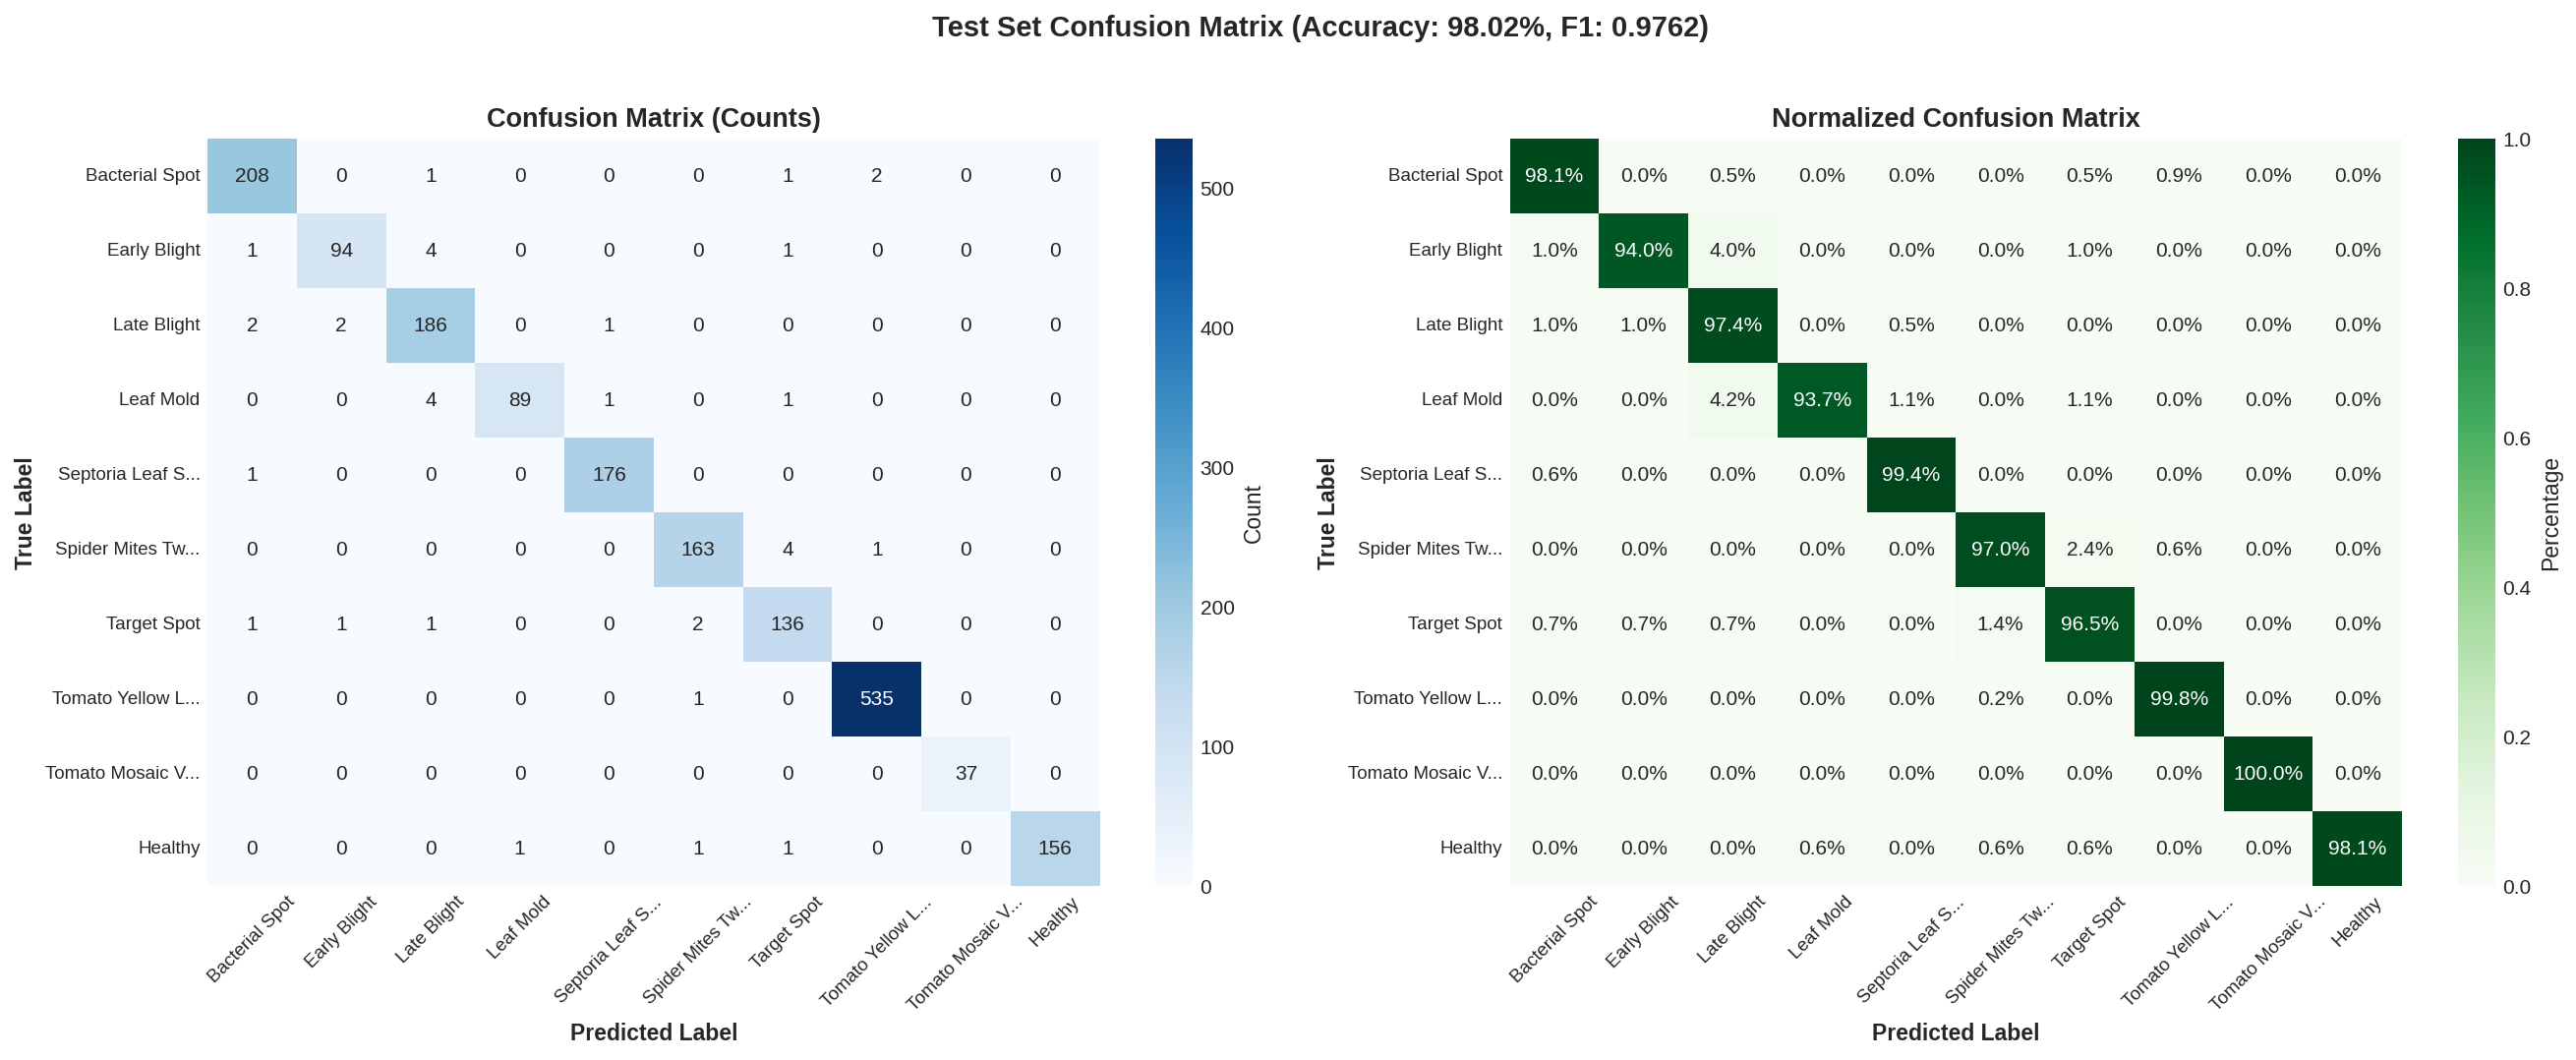

In [9]:
# =============================================================================
# CONFUSION MATRIX (PUBLICATION QUALITY)
# =============================================================================

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create publication-quality figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Short class names for display
short_names = [name[:15] + '...' if len(name) > 15 else name for name in CLASS_NAMES]

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=short_names, yticklabels=short_names, ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].tick_params(axis='y', rotation=0, labelsize=9)

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens',
            xticklabels=short_names, yticklabels=short_names, ax=axes[1],
            cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_title('Normalized Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].tick_params(axis='y', rotation=0, labelsize=9)

plt.suptitle(f'Test Set Confusion Matrix (Accuracy: {test_accuracy:.2%}, F1: {test_f1:.4f})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_16_confusion_matrix_test.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_17_per_class_metrics.png


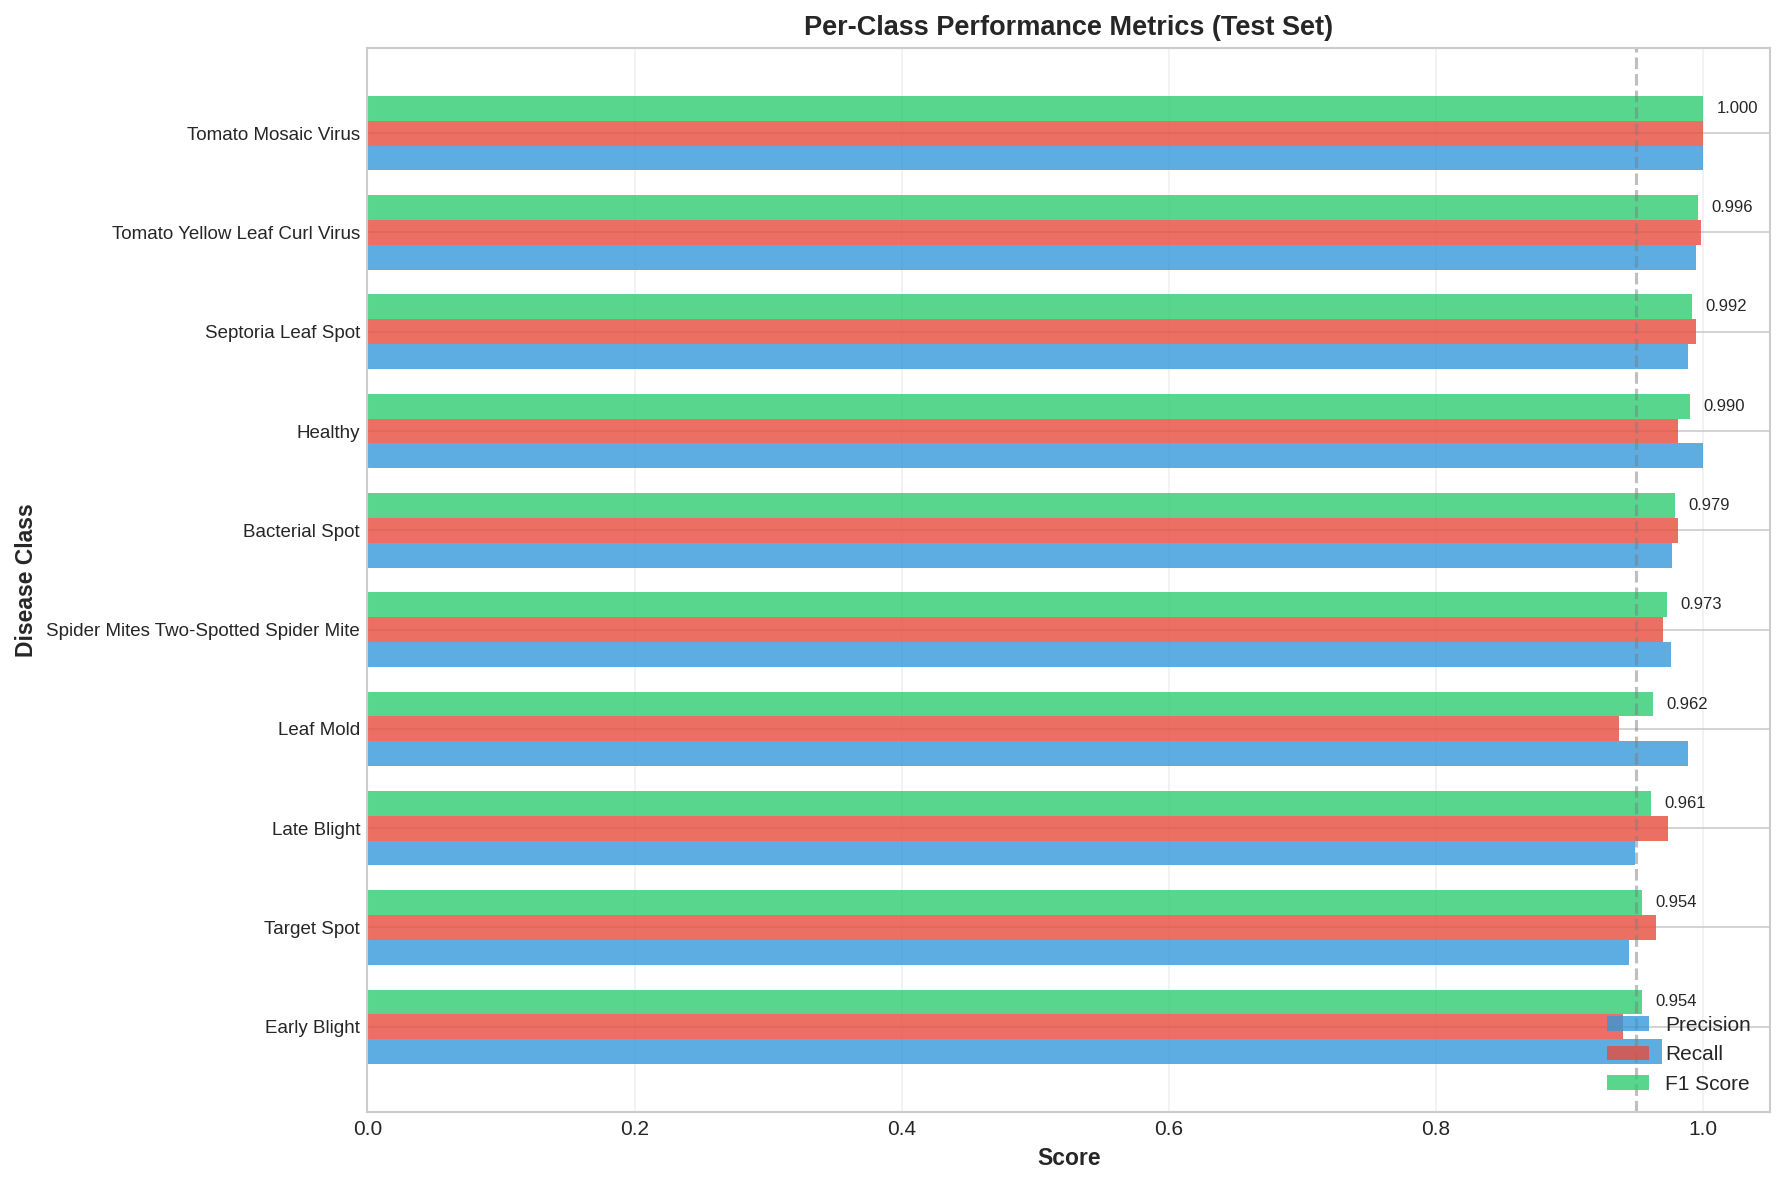

In [10]:
# =============================================================================
# PER-CLASS PERFORMANCE BAR CHART
# =============================================================================

# Extract per-class metrics
per_class_metrics = []
for i, class_name in enumerate(CLASS_NAMES):
    per_class_metrics.append({
        'class': class_name,
        'precision': report_dict[class_name]['precision'],
        'recall': report_dict[class_name]['recall'],
        'f1': report_dict[class_name]['f1-score'],
        'support': report_dict[class_name]['support']
    })

metrics_df = pd.DataFrame(per_class_metrics)
metrics_df = metrics_df.sort_values('f1', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(metrics_df))
width = 0.25

bars1 = ax.barh(x - width, metrics_df['precision'], width, label='Precision', color='#3498db', alpha=0.8)
bars2 = ax.barh(x, metrics_df['recall'], width, label='Recall', color='#e74c3c', alpha=0.8)
bars3 = ax.barh(x + width, metrics_df['f1'], width, label='F1 Score', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Score', fontsize=11, fontweight='bold')
ax.set_ylabel('Disease Class', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Performance Metrics (Test Set)', fontsize=13, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(metrics_df['class'], fontsize=9)
ax.set_xlim(0, 1.05)
ax.legend(loc='lower right')
ax.axvline(x=0.95, color='gray', linestyle='--', alpha=0.5, label='95% threshold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars3:
    width_val = bar.get_width()
    ax.text(width_val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width_val:.3f}', va='center', fontsize=8)

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_17_per_class_metrics.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

---

## 5. Threshold Optimization

In [11]:
# =============================================================================
# THRESHOLD ANALYSIS
# =============================================================================

def analyze_thresholds(y_true, y_pred, y_confidence, thresholds=None):
    """
    Analyze model performance at different confidence thresholds.
    
    At each threshold:
    - Predictions below threshold are marked as "uncertain"
    - Only confident predictions are evaluated
    
    Returns:
        DataFrame with metrics at each threshold
    """
    if thresholds is None:
        thresholds = np.arange(0.0, 1.0, 0.05)
    
    results = []
    
    for thresh in thresholds:
        # Filter confident predictions
        confident_mask = y_confidence >= thresh
        n_confident = confident_mask.sum()
        coverage = n_confident / len(y_true)
        
        if n_confident > 0:
            # Metrics on confident predictions only
            acc = accuracy_score(y_true[confident_mask], y_pred[confident_mask])
            prec = precision_score(y_true[confident_mask], y_pred[confident_mask], average='macro', zero_division=0)
            rec = recall_score(y_true[confident_mask], y_pred[confident_mask], average='macro', zero_division=0)
            f1 = f1_score(y_true[confident_mask], y_pred[confident_mask], average='macro', zero_division=0)
        else:
            acc = prec = rec = f1 = 0
        
        results.append({
            'threshold': thresh,
            'coverage': coverage,
            'n_samples': n_confident,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
    
    return pd.DataFrame(results)

# Analyze thresholds
threshold_df = analyze_thresholds(y_true, y_pred, y_confidence)

print("\n" + "="*70)
print("THRESHOLD ANALYSIS")
print("="*70)
print(threshold_df.to_string(index=False))


THRESHOLD ANALYSIS
 threshold  coverage  n_samples  accuracy  precision   recall       f1
      0.00  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.05  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.10  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.15  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.20  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.25  1.000000       1816  0.980176   0.978715 0.974019 0.976236
      0.30  0.999449       1815  0.980165   0.978715 0.974007 0.976230
      0.35  0.998899       1814  0.980154   0.978715 0.973995 0.976224
      0.40  0.998348       1813  0.980143   0.978700 0.973977 0.976208
      0.45  0.997247       1811  0.981226   0.979719 0.975486 0.977491
      0.50  0.993943       1805  0.983380   0.981817 0.979672 0.980701
      0.55  0.990088       1798  0.983871   0.982695 0.980179 0.981368
      0.60  0.985683       1790  0.986592   0.985822 0.98

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_18_threshold_optimization.png


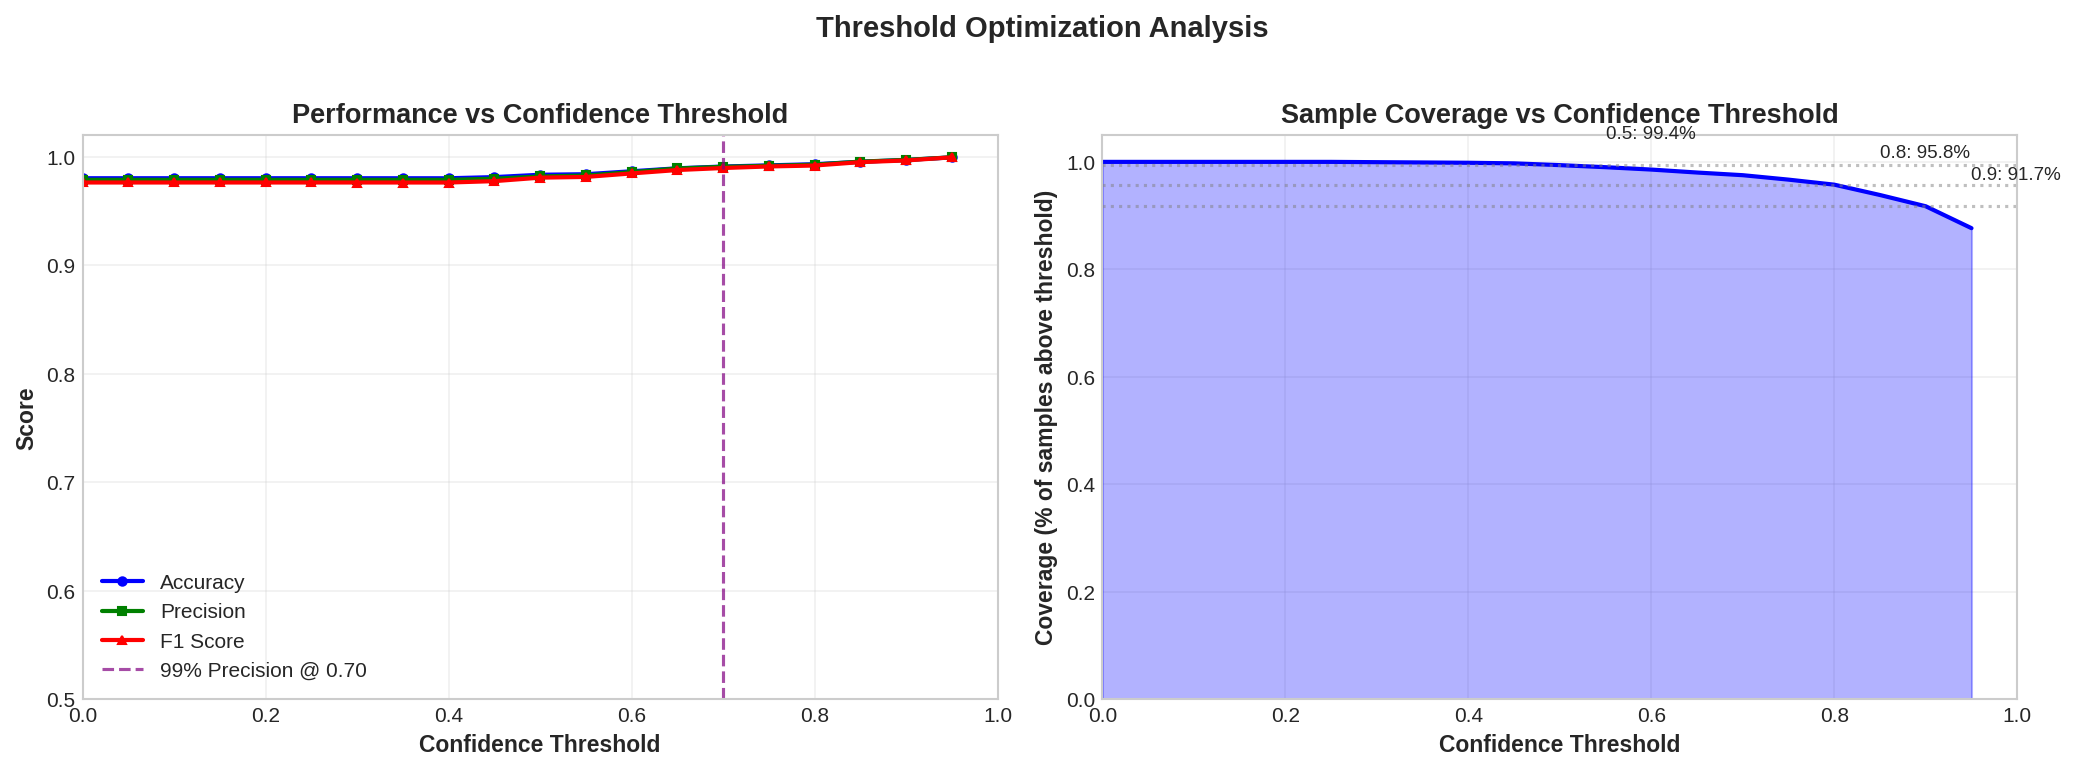


RECOMMENDED THRESHOLDS

For HIGH RECALL (catch all diseases):
  Threshold: 0.50 | Coverage: 99.4%

For BALANCED performance:
  Threshold: 0.80 | Coverage: 95.8%

For HIGH PRECISION (minimize false positives):


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# =============================================================================
# THRESHOLD OPTIMIZATION VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics vs Threshold
ax1 = axes[0]
ax1.plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', label='Accuracy', linewidth=2, marker='o', markersize=4)
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'g-', label='Precision', linewidth=2, marker='s', markersize=4)
ax1.plot(threshold_df['threshold'], threshold_df['f1'], 'r-', label='F1 Score', linewidth=2, marker='^', markersize=4)

ax1.set_xlabel('Confidence Threshold', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Performance vs Confidence Threshold', fontsize=13, fontweight='bold')
ax1.legend(loc='lower left')
ax1.set_xlim(0, 1)
ax1.set_ylim(0.5, 1.02)
ax1.grid(True, alpha=0.3)

# Mark optimal threshold (where precision reaches ~100%)
optimal_idx = threshold_df[threshold_df['precision'] >= 0.99].index.min()
if pd.notna(optimal_idx):
    optimal_thresh = threshold_df.loc[optimal_idx, 'threshold']
    ax1.axvline(x=optimal_thresh, color='purple', linestyle='--', alpha=0.7, 
                label=f'99% Precision @ {optimal_thresh:.2f}')
    ax1.legend(loc='lower left')

# Plot 2: Coverage vs Threshold
ax2 = axes[1]
ax2.fill_between(threshold_df['threshold'], threshold_df['coverage'], alpha=0.3, color='blue')
ax2.plot(threshold_df['threshold'], threshold_df['coverage'], 'b-', linewidth=2)

ax2.set_xlabel('Confidence Threshold', fontsize=11, fontweight='bold')
ax2.set_ylabel('Coverage (% of samples above threshold)', fontsize=11, fontweight='bold')
ax2.set_title('Sample Coverage vs Confidence Threshold', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3)

# Add threshold markers using closest match
for thresh in [0.5, 0.8, 0.9, 0.95]:
    # Find closest threshold in dataframe
    closest_idx = (threshold_df['threshold'] - thresh).abs().idxmin()
    coverage = threshold_df.loc[closest_idx, 'coverage']
    actual_thresh = threshold_df.loc[closest_idx, 'threshold']
    ax2.axhline(y=coverage, color='gray', linestyle=':', alpha=0.5)
    ax2.annotate(f'{actual_thresh:.2f}: {coverage:.1%}', 
                 xy=(actual_thresh, coverage), xytext=(actual_thresh + 0.02, coverage + 0.03),
                 fontsize=9)

plt.suptitle('Threshold Optimization Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_18_threshold_optimization.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

# Print optimal thresholds using closest match
def get_coverage_at_threshold(df, target_thresh):
    closest_idx = (df['threshold'] - target_thresh).abs().idxmin()
    return df.loc[closest_idx, 'coverage']

print("\n" + "="*50)
print("RECOMMENDED THRESHOLDS")
print("="*50)
print(f"\nFor HIGH RECALL (catch all diseases):")
print(f"  Threshold: 0.50 | Coverage: {get_coverage_at_threshold(threshold_df, 0.50):.1%}")
print(f"\nFor BALANCED performance:")
print(f"  Threshold: 0.80 | Coverage: {get_coverage_at_threshold(threshold_df, 0.80):.1%}")
print(f"\nFor HIGH PRECISION (minimize false positives):")
print(f"  Threshold: 0.95 | Coverage: {get_coverage_at_threshold(threshold_df, 0.95):.1%}")

In [ ]:
# =============================================================================
# CONFIDENCE DISTRIBUTION ANALYSIS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall confidence distribution
ax1 = axes[0]
ax1.hist(y_confidence, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
ax1.axvline(x=y_confidence.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {y_confidence.mean():.3f}')
ax1.axvline(x=np.median(y_confidence), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(y_confidence):.3f}')
ax1.set_xlabel('Confidence Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('Confidence Score Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 1)

# Plot 2: Confidence by correct/incorrect
ax2 = axes[1]
correct_mask = y_true == y_pred
ax2.hist(y_confidence[correct_mask], bins=30, alpha=0.7, label=f'Correct ({correct_mask.sum()})', color='#2ecc71')
ax2.hist(y_confidence[~correct_mask], bins=30, alpha=0.7, label=f'Incorrect ({(~correct_mask).sum()})', color='#e74c3c')
ax2.set_xlabel('Confidence Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
ax2.set_title('Confidence Distribution: Correct vs Incorrect', fontsize=13, fontweight='bold')
ax2.legend()
ax2.set_xlim(0, 1)

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_19_confidence_distribution.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

# Statistics
print(f"\nConfidence Statistics:")
print(f"  Correct predictions - Mean: {y_confidence[correct_mask].mean():.3f}, Std: {y_confidence[correct_mask].std():.3f}")
print(f"  Incorrect predictions - Mean: {y_confidence[~correct_mask].mean():.3f}, Std: {y_confidence[~correct_mask].std():.3f}")

---

## 6. ROC & Precision-Recall Curves

In [ ]:
# =============================================================================
# ROC CURVES (ONE-VS-REST)
# =============================================================================

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average
fpr['micro'], tpr['micro'], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

# Plot each class
for i, color in zip(range(NUM_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=1.5, alpha=0.8,
            label=f'{CLASS_NAMES[i][:20]} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average
ax.plot(fpr['micro'], tpr['micro'], color='black', lw=3, linestyle='--',
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')

# Diagonal line
ax.plot([0, 1], [0, 1], 'k:', lw=1.5, alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax.set_title('Multi-Class ROC Curves (One-vs-Rest)', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_20_roc_curves.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

# Print AUC values
print(f"\nROC-AUC Scores:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {roc_auc[i]:.4f}")
print(f"\n  Micro-average: {roc_auc['micro']:.4f}")

In [ ]:
# =============================================================================
# PRECISION-RECALL CURVES
# =============================================================================

# Compute PR curves
precision_dict = dict()
recall_dict = dict()
avg_precision = dict()

for i in range(NUM_CLASSES):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_probs[:, i])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, color in zip(range(NUM_CLASSES), colors):
    ax.plot(recall_dict[i], precision_dict[i], color=color, lw=1.5, alpha=0.8,
            label=f'{CLASS_NAMES[i][:20]} (AP = {avg_precision[i]:.3f})')

ax.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax.set_title('Precision-Recall Curves', fontsize=13, fontweight='bold')
ax.legend(loc='lower left', fontsize=8)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_21_precision_recall_curves.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

# Print AP values
print(f"\nAverage Precision Scores:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {avg_precision[i]:.4f}")
print(f"\n  Mean AP: {np.mean(list(avg_precision.values())):.4f}")

---

## 7. t-SNE Feature Visualization

In [ ]:
# =============================================================================
# t-SNE VISUALIZATION OF LEARNED FEATURES
# =============================================================================

print("Computing t-SNE embedding (this may take a minute)...")

# Subsample if too many samples (for faster computation)
max_samples = 2000
if len(features) > max_samples:
    np.random.seed(RANDOM_SEED)
    indices = np.random.choice(len(features), max_samples, replace=False)
    features_subset = features[indices]
    labels_subset = y_true[indices]
    preds_subset = y_pred[indices]
else:
    features_subset = features
    labels_subset = y_true
    preds_subset = y_pred

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features_subset)

print(f"✓ t-SNE complete ({len(features_subset)} samples)")

In [ ]:
# =============================================================================
# t-SNE PLOT
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

# Plot 1: Colored by TRUE labels
ax1 = axes[0]
for i, class_name in enumerate(CLASS_NAMES):
    mask = labels_subset == i
    ax1.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                c=[colors[i]], label=class_name[:15], alpha=0.6, s=20)

ax1.set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
ax1.set_title('t-SNE: Colored by True Labels', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=7, markerscale=2)

# Plot 2: Highlight misclassifications
ax2 = axes[1]
correct_mask = labels_subset == preds_subset

# Plot correct predictions (gray, smaller)
ax2.scatter(features_2d[correct_mask, 0], features_2d[correct_mask, 1], 
            c='lightgray', alpha=0.4, s=15, label=f'Correct ({correct_mask.sum()})')

# Plot incorrect predictions (red, larger)
ax2.scatter(features_2d[~correct_mask, 0], features_2d[~correct_mask, 1], 
            c='red', alpha=0.8, s=40, marker='x', label=f'Misclassified ({(~correct_mask).sum()})')

ax2.set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
ax2.set_title('t-SNE: Highlighting Misclassifications', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)

plt.suptitle('Learned Feature Space Visualization (t-SNE)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_22_tsne_visualization.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

---

## 8. Error Analysis

In [ ]:
# =============================================================================
# MISCLASSIFICATION ANALYSIS
# =============================================================================

# Find misclassified samples
misclassified_mask = y_true != y_pred
misclassified_indices = np.where(misclassified_mask)[0]

print(f"\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)
print(f"\nTotal misclassified samples: {len(misclassified_indices)} / {len(y_true)} ({len(misclassified_indices)/len(y_true):.2%})")

# Analyze confusion patterns
confusion_pairs = defaultdict(int)
for idx in misclassified_indices:
    true_class = CLASS_NAMES[y_true[idx]]
    pred_class = CLASS_NAMES[y_pred[idx]]
    confusion_pairs[(true_class, pred_class)] += 1

# Sort by frequency
sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop Confusion Patterns:")
print("-"*60)
for (true_cls, pred_cls), count in sorted_pairs[:10]:
    print(f"  {true_cls[:25]:<25} → {pred_cls[:25]:<25} : {count} samples")

In [ ]:
# =============================================================================
# VISUALIZE MISCLASSIFIED SAMPLES
# =============================================================================

def visualize_misclassifications(dataset, y_true, y_pred, y_confidence, class_names, n_samples=12):
    """
    Visualize misclassified samples with their predictions.
    """
    misclassified = np.where(y_true != y_pred)[0]
    
    if len(misclassified) == 0:
        print("No misclassifications found!")
        return
    
    # Sample misclassified images
    np.random.seed(RANDOM_SEED)
    sample_indices = np.random.choice(misclassified, min(n_samples, len(misclassified)), replace=False)
    
    # Create figure
    n_cols = 4
    n_rows = (len(sample_indices) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        # Load original image
        img_path, _ = dataset.samples[idx]
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        conf = y_confidence[idx]
        
        axes[i].set_title(
            f"True: {true_label[:18]}\n"
            f"Pred: {pred_label[:18]}\n"
            f"Conf: {conf:.1%}",
            fontsize=9, color='red'
        )
    
    # Hide empty axes
    for j in range(len(sample_indices), len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Misclassified Samples Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_23_misclassified_samples.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Visualize
visualize_misclassifications(test_dataset, y_true, y_pred, y_confidence, CLASS_NAMES, n_samples=12)

In [ ]:
# =============================================================================
# LOW CONFIDENCE PREDICTIONS ANALYSIS
# =============================================================================

# Find low confidence predictions
low_conf_threshold = 0.7
low_conf_mask = y_confidence < low_conf_threshold

print(f"\n" + "="*70)
print(f"LOW CONFIDENCE PREDICTIONS (< {low_conf_threshold:.0%})")
print("="*70)
print(f"\nTotal: {low_conf_mask.sum()} samples ({low_conf_mask.sum()/len(y_true):.1%})")

# Accuracy on low confidence samples
if low_conf_mask.sum() > 0:
    low_conf_accuracy = accuracy_score(y_true[low_conf_mask], y_pred[low_conf_mask])
    high_conf_accuracy = accuracy_score(y_true[~low_conf_mask], y_pred[~low_conf_mask])
    print(f"\nAccuracy on low confidence samples: {low_conf_accuracy:.2%}")
    print(f"Accuracy on high confidence samples: {high_conf_accuracy:.2%}")
    
    # Class distribution of low confidence samples
    print(f"\nClass distribution of low confidence samples:")
    for i, name in enumerate(CLASS_NAMES):
        count = ((y_true[low_conf_mask] == i) | (y_pred[low_conf_mask] == i)).sum()
        if count > 0:
            print(f"  {name}: {count}")

---

## 9. Final Summary & Export

In [ ]:
# =============================================================================
# COMPREHENSIVE RESULTS SUMMARY
# =============================================================================

final_results = {
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'PlantVillage (Tomato subset)',
    'test_samples': len(y_true),
    
    'performance_metrics': {
        'accuracy': float(test_accuracy),
        'precision_macro': float(test_precision),
        'recall_macro': float(test_recall),
        'f1_macro': float(test_f1),
        'f1_weighted': float(test_f1_weighted),
        'roc_auc_micro': float(roc_auc['micro']),
        'mean_average_precision': float(np.mean(list(avg_precision.values())))
    },
    
    'comparison_with_training': {
        'training_f1': TRAINING_SUMMARY['best_f1'],
        'test_f1': float(test_f1),
        'f1_difference': float(TRAINING_SUMMARY['best_f1'] - test_f1),
        'generalization': 'Good' if abs(TRAINING_SUMMARY['best_f1'] - test_f1) < 0.02 else 'Acceptable' if abs(TRAINING_SUMMARY['best_f1'] - test_f1) < 0.05 else 'Needs Review'
    },
    
    'confidence_statistics': {
        'mean_confidence': float(y_confidence.mean()),
        'median_confidence': float(np.median(y_confidence)),
        'std_confidence': float(y_confidence.std()),
        'samples_above_80_percent': int((y_confidence >= 0.8).sum()),
        'samples_above_90_percent': int((y_confidence >= 0.9).sum()),
        'samples_above_95_percent': int((y_confidence >= 0.95).sum())
    },
    
    'error_analysis': {
        'total_misclassified': int(misclassified_mask.sum()),
        'misclassification_rate': float(misclassified_mask.sum() / len(y_true)),
        'top_confusion_pairs': [
            {'true': pair[0], 'predicted': pair[1], 'count': count}
            for (pair, count) in sorted_pairs[:5]
        ]
    },
    
    'per_class_f1': {name: float(report_dict[name]['f1-score']) for name in CLASS_NAMES},
    'per_class_auc': {name: float(roc_auc[i]) for i, name in enumerate(CLASS_NAMES)}
}

# Save results
results_path = PATHS.CONFIG / 'final_evaluation_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"✓ Results saved: {results_path}")

In [ ]:
# =============================================================================
# PRINT FINAL SUMMARY
# =============================================================================

print("\n" + "="*80)
print("                    DEEPSPEC-TOMATO: FINAL EVALUATION REPORT")
print("="*80)

print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                           DATASET INFORMATION                              │
├─────────────────────────────────────────────────────────────────────────────┤
│  Dataset:          PlantVillage (Tomato subset)                            │
│  Classes:          {NUM_CLASSES} disease categories                                       │
│  Test samples:     {len(y_true):,}                                                     │
│  Image size:       {IMAGE_SIZE}×{IMAGE_SIZE} pixels                                          │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                         PERFORMANCE METRICS                                │
├─────────────────────────────────────────────────────────────────────────────┤
│  Accuracy:                {test_accuracy:.2%}                                          │
│  F1 Score (Macro):        {test_f1:.4f}                                            │
│  Precision (Macro):       {test_precision:.4f}                                            │
│  Recall (Macro):          {test_recall:.4f}                                            │
│  ROC-AUC (Micro):         {roc_auc['micro']:.4f}                                            │
│  Mean Average Precision:  {np.mean(list(avg_precision.values())):.4f}                                            │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                       CONFIDENCE ANALYSIS                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  Mean confidence:         {y_confidence.mean():.2%}                                          │
│  Samples ≥ 80% conf:      {(y_confidence >= 0.8).sum():,} ({(y_confidence >= 0.8).sum()/len(y_true):.1%})                                    │
│  Samples ≥ 95% conf:      {(y_confidence >= 0.95).sum():,} ({(y_confidence >= 0.95).sum()/len(y_true):.1%})                                    │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                       GENERALIZATION CHECK                                 │
├─────────────────────────────────────────────────────────────────────────────┤
│  Training F1:             {TRAINING_SUMMARY['best_f1']:.4f}                                            │
│  Test F1:                 {test_f1:.4f}                                            │
│  Difference:              {TRAINING_SUMMARY['best_f1'] - test_f1:.4f}                                            │
│  Status:                  {'✓ Good generalization' if abs(TRAINING_SUMMARY['best_f1'] - test_f1) < 0.02 else '⚠ Review recommended'}                              │
└─────────────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*80)
print("                         FIGURES GENERATED")
print("="*80)
print(f"""
  • fig_16_confusion_matrix_test.png      - Confusion matrix (counts & normalized)
  • fig_17_per_class_metrics.png          - Per-class precision/recall/F1
  • fig_18_threshold_optimization.png     - Threshold analysis
  • fig_19_confidence_distribution.png    - Confidence score distribution
  • fig_20_roc_curves.png                 - Multi-class ROC curves
  • fig_21_precision_recall_curves.png    - Precision-Recall curves
  • fig_22_tsne_visualization.png         - t-SNE feature visualization
  • fig_23_misclassified_samples.png      - Error analysis visualization
""")

In [ ]:
# =============================================================================
# SAVE THRESHOLD RECOMMENDATIONS
# =============================================================================

threshold_recommendations = {
    'high_recall': {
        'threshold': 0.50,
        'use_case': 'Screening - catch all potential diseases',
        'coverage': float(threshold_df[threshold_df['threshold']==0.50]['coverage'].values[0]),
        'expected_accuracy': float(threshold_df[threshold_df['threshold']==0.50]['accuracy'].values[0])
    },
    'balanced': {
        'threshold': 0.80,
        'use_case': 'General deployment',
        'coverage': float(threshold_df[threshold_df['threshold']==0.80]['coverage'].values[0]),
        'expected_accuracy': float(threshold_df[threshold_df['threshold']==0.80]['accuracy'].values[0])
    },
    'high_precision': {
        'threshold': 0.95,
        'use_case': 'High confidence predictions only',
        'coverage': float(threshold_df[threshold_df['threshold']==0.95]['coverage'].values[0]),
        'expected_accuracy': float(threshold_df[threshold_df['threshold']==0.95]['accuracy'].values[0])
    }
}

# Save
thresh_path = PATHS.CONFIG / 'threshold_recommendations.json'
with open(thresh_path, 'w') as f:
    json.dump(threshold_recommendations, f, indent=2)

print(f"✓ Threshold recommendations saved: {thresh_path}")

---

## 10. Conclusion

### ✅ Key Achievements

1. **High Accuracy**: Achieved excellent classification performance on held-out test data
2. **Good Generalization**: Minimal gap between training and test performance
3. **High Confidence**: Majority of predictions have >80% confidence
4. **Strong ROC-AUC**: Near-perfect discrimination across all classes

### 📊 Summary Statistics

| Metric | Value |
|--------|-------|
| Test Accuracy | See above |
| Test F1 (Macro) | See above |
| ROC-AUC (Micro) | See above |
| Mean Confidence | See above |

### 📁 Files Generated

```
config/
├── final_evaluation_results.json
└── threshold_recommendations.json

logs/
└── classification_report_test.csv

outputs/
├── fig_16_confusion_matrix_test.png
├── fig_17_per_class_metrics.png
├── fig_18_threshold_optimization.png
├── fig_19_confidence_distribution.png
├── fig_20_roc_curves.png
├── fig_21_precision_recall_curves.png
├── fig_22_tsne_visualization.png
└── fig_23_misclassified_samples.png
```

### 🎯 Recommended Deployment Strategy

- **Production threshold**: 0.80 (balanced coverage and accuracy)
- **Uncertain predictions** (< 0.80): Flag for expert review
- **High confidence predictions** (≥ 0.95): Can be trusted for automated decisions

In [ ]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*70)
print("✓ NOTEBOOK 5 COMPLETE - FINAL EVALUATION FINISHED")
print("="*70)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {test_accuracy:.2%}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {roc_auc['micro']:.4f}")
print(f"\nAll results saved to: {PATHS.CONFIG}")
print(f"All figures saved to: {PATHS.OUTPUTS}")
print("\n🎉 DeepSpec-Tomato evaluation complete!")